In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.linear_model import Ridge, Lasso

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from warnings import filterwarnings

filterwarnings('ignore')

%matplotlib inline

sns.set(style="darkgrid")
pd.options.display.max_rows = 200
pd.options.display.max_columns = 200

**Task 1**. We will be working with data from the [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview) competition, which was about predicting the duration of a taxi trip. Download the training sample from this competition and upload it:

In [44]:
train = pd.read_csv('Untitled Folder/train.csv')

In [45]:
train.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663


Pay attention to the `pickup_datetime` and `dropoff_datetime` columns. `dropoff_datetime` was added only to the training sample, so, this column cannot be used, let's delete it. `pickup_datetime` contains the date and time the trip started. To make it convenient to work with, let's convert dates to `datetime` objects

In [46]:
train = train.drop('dropoff_datetime', axis=1)
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)

target = 'trip_duration'

The `trip_duration` column contains the target value we want to predict. Let's look at the distribution of the target in the training sample. To do this, draw its histogram:

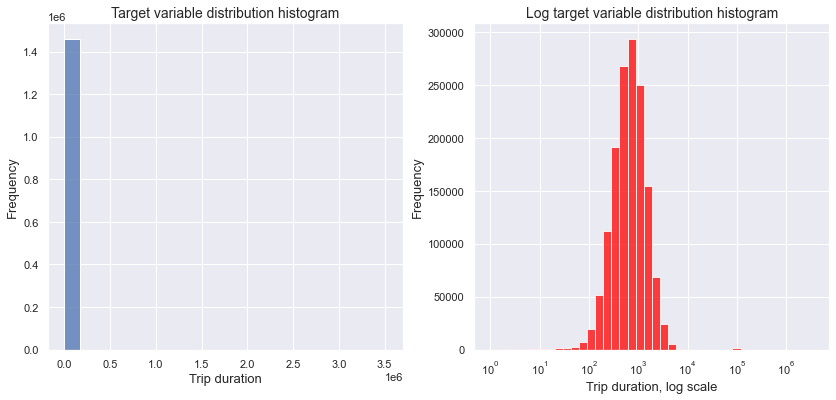

In [47]:
plt.rcParams["figure.figsize"] = (14,6)

fig, ax = plt.subplots(ncols=2)

sns.histplot(data=train, x=target, bins=20, ax=ax[0])
#plot similar histogram with parameter log_scale, choose informative amount of bins and correct axis
#your code here
sns.histplot(data = train, x = target, bins = 40, ax=ax[1], color = 'red', log_scale = True )
#end of your code


ax[0].set_title('Target variable distribution histogram', dict(size=14))
ax[0].set_xlabel('Trip duration', dict(size=13))
ax[0].set_ylabel('Frequency', dict(size=13))

ax[1].set_title('Log target variable distribution histogram', dict(size=14))
ax[1].set_xlabel('Trip duration, log scale', dict(size=13))
histogram = ax[1].set_ylabel('Frequency', dict(size=13))

**Question**: Why is it necessary to build a histogram in a logarithmic scale?

**Answer**

In logarithmic scale we can see more information about our data. Where it's grown and where it's fallen, and that information is imortant when we try take big picture about our information. Furthermore that better for checking anomalyes.

The competition used RMSLE as a quality metric:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Question**: Why do you think the contest authors chose RMSLE and not RMSE?

**Answer:** RMSE will have a drastic effect of outliers on its values. But in case of RMSLE we can reduce the effect of outliers by many magnitudes & their effect is much less. RMSLE value will only consider the relative error between Predicted and the actual value neglecting the scale of data. But RMSE value will increase in magnitude if the scale of error increases.

We have discussed several linear regression models in `sklearn`, but each of them optimized the mean square error (MSE), not RMSLE. Let's do the following trick: we will predict not the target variable, but its *logarithm*. Let $\hat{y}_i = \log{(y_i + 1)}$ be the modified target, and $\hat{a}(x_i)$ be the prediction of the model trained on $\hat{y}_i$, that is, the logarithm of the target. To predict the original value, we can simply take the exponent of our prediction: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

In addition, the logarithm of the target has another useful quality. To see it, add the `log_trip_duration` column to our sample (use `np.log1p`) and draw a histogram of the modified target for the training sample. Delete the column with the old target.

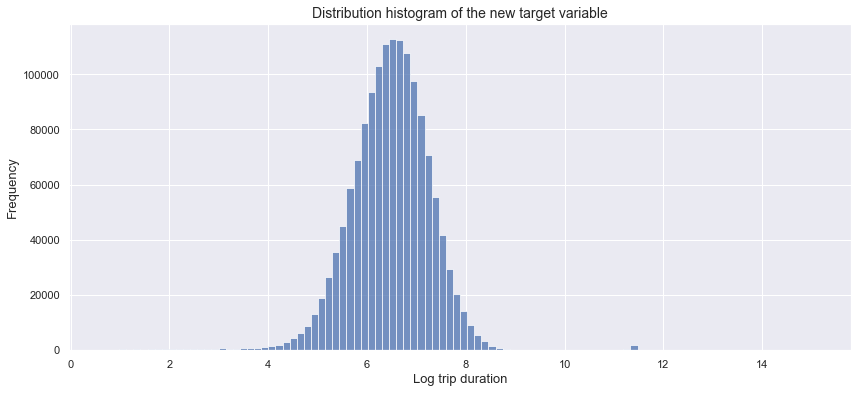

In [48]:
train['log_trip_duration'] = np.log1p(train[target])
#your code to delet target column from train is here:
train = train.drop('trip_duration', axis=1)
#end of your code
target = 'log_trip_duration'

plt.title('Distribution histogram of the new target variable', dict(size=14))
plt.xlabel('Log trip duration', dict(size=13))
plt.ylabel('Frequency', dict(size=13))
_ = sns.histplot(data=train, x=target, bins=100)

Let's calculate the value of the metric with the best constant prediction:

**Question**: why the best constant for RMSE is mean value?

**Answer**: If we want to have a constant forecast, the best is an average of the target values.

In [49]:
def RMSE(y_true, y_pred):
    return ((y_true - y_pred) ** 2).mean() ** .5

In [50]:
#your code to find constant prediction here:
const_model = train[target].mean()
#end of your code
print('Best constant prediction value: {}'.format(RMSE(train[target], const_model)))

Best constant prediction value: 0.7957592365412156


**Task 2**. First, let's see how many trips there were on each day. Plot the number of trips versus the day of the year:

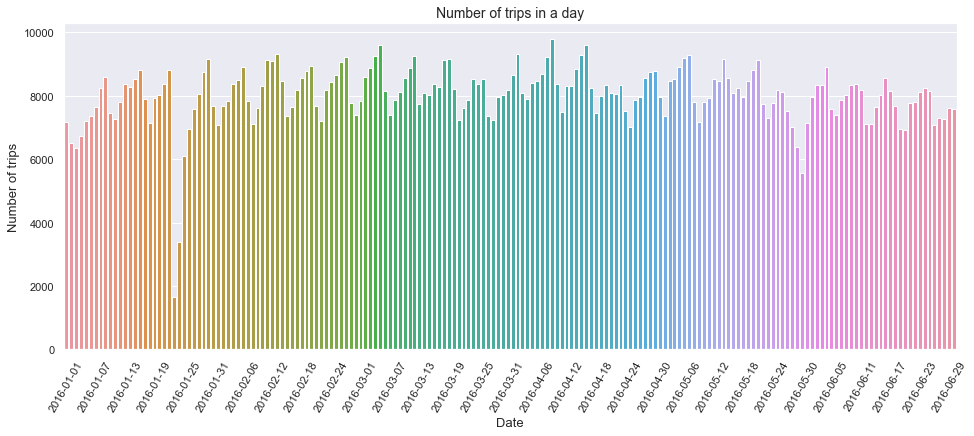

In [51]:
plt.rcParams["figure.figsize"] = (16,6)
train['day_of_year'] = train.pickup_datetime.dt.day_of_year

sns.countplot(x=train['day_of_year'])

plt.title('Number of trips in a day', dict(size=14))
plt.xlabel('Date', dict(size=13))
plt.ylabel('Number of trips', dict(size=13))

_ = plt.xticks(np.arange(0, 181, 6), np.unique(train.pickup_datetime.dt.date)[::6], rotation=60)

**Question**: You may have noticed that there are 2 periods on the graph with abnormally low numbers of trips. Calculate the dates on which these downward swings occurred and find information about what happened on those days in New York.

**Answer**: On January 20–22, the governors of eleven states and the mayor of Washington, D.C. declared a state of emergency in anticipation of significant snowfall and blizzard conditions. Approximately 103 million people were affected by the storm, with 33 million people placed under blizzard warnings. More than 13,000 flights were cancelled in relation to the storm, with effects rippling internationally. Thousands of National Guardsmen were placed on standby, and states deployed millions of gallons of brine and thousands of tons of road salt to lessen the storm's effect on roadways. A travel ban was instituted for New York City and Newark, New Jersey for January 23–24. The storm was given various unofficial names, including Winter Storm Jonas, Blizzard of 2016, and Snowzilla. ( Wikipedia, 2022 )



Plot the number of trips versus the day of the week and the hours of the day (use `sns.relplot`):

In [52]:
train['hour'] = train.pickup_datetime.dt.hour
train['day_of_week'] = train.pickup_datetime.dt.day_of_week
train['day_of_year'] = train.pickup_datetime.dt.day_of_year
train['month_name'] = train.pickup_datetime.dt.month_name()

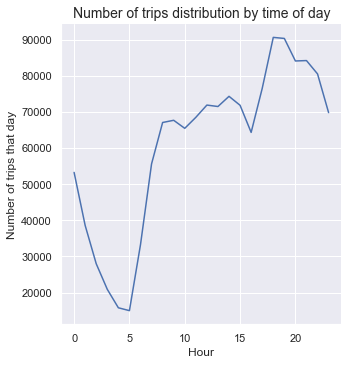

In [53]:
tmp_data = train.groupby('hour').id.count()\
.reset_index().rename({
    'hour': 'Hour',
    'id': 'Number of trips that day'},
    axis=1
)

sns.relplot(data=tmp_data,
            x='Hour',
            y='Number of trips that day',
            kind='line')
_ = plt.title('Number of trips distribution by time of day', dict(size=14))

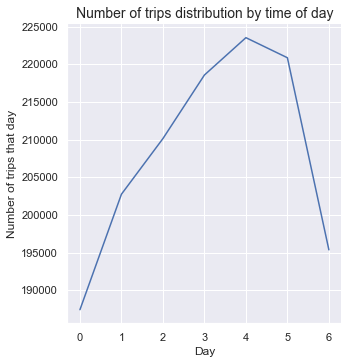

In [54]:
#your code for number of trips distribution by day of week
tmp_data = train.groupby('day_of_week').id.count()\
.reset_index().rename({
    'day_of_week': 'Day',
    'id': 'Number of trips that day'},
    axis=1
)

sns.relplot(data=tmp_data,
            x='Day',
            y='Number of trips that day',
            kind='line')
_ = plt.title('Number of trips distribution by time of day', dict(size=14))

**Task 3**. Draw on one graph the dependence of the number of trips on the hour of the day for different months (different curves corresponding to different months, color in different colors with use of `hue` in `sns.relplot`). Similarly, draw the dependence of the number of trips on the hour of the day for different days of the week.

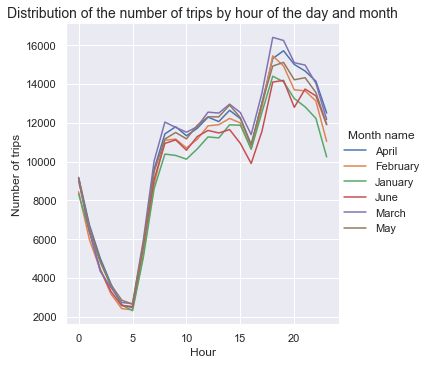

In [55]:
tmp_data = train.groupby(['month_name', 'hour']).id.count()\
.reset_index().rename({
    'month_name': 'Month name',
    'hour': 'Hour',
    'id': 'Number of trips'},
    axis=1
)

sns.relplot(data=tmp_data,
            x='Hour',
            y='Number of trips',
            hue='Month name',
            kind='line')
_ = plt.title('Distribution of the number of trips by hour of the day and month', dict(size=14))

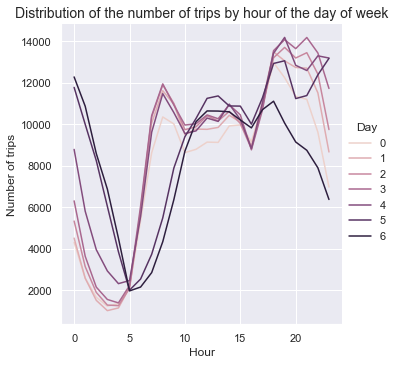

In [56]:
#your code for the dependence of the number of trips on the hour of the day for different days of the week is here:
tmp_data2 = train.groupby(['day_of_week', 'hour']).id.count()\
.reset_index().rename({
    'day_of_week': 'Day',
    'hour': 'Hour',
    'id': 'Number of trips'},
    axis = 1
)

sns.relplot( data = tmp_data2, x = 'Hour', y = 'Number of trips', hue = 'Day', kind = 'line')
_ = plt.title('Distribution of the number of trips by hour of the day of week', dict(size=14))
#end of your code

**Question**: What conclusions can be drawn based on the graphs above? Are there any special days of the week? Months? Times of Day? What is it connected with?

**Answer**: Wednesday, Thursday and Friday are the most popular days for taxi. By the way, the peak time for calling a cab is between 6 and 7 a.m., when people go to work, and between 6 and 9 p.m., when people go from work. March is the most popular month for cab rides, this may be due to the frequent rains and bad weather in March in New York City.

**Task 4**. Split the sample into train and test (7:3). For the train sample, plot the mean logarithm of travel time versus day of the week. Then do the same, but for the hour of the day and the day of the year.

Add the following traits based on `pickup_datetime`:
1. Day of the week
2. Month
3. Hour
4. Is the period anomalous (two binary signs corresponding to two anomalous periods)
5. Number of the day in the year

In [57]:
train = train.drop('month_name', axis=1)
train['month'] = train.pickup_datetime.dt.month

train['is_anomaly_jan'] = ((23 <= train.day_of_year) & (train.day_of_year <= 26)).astype('int')
train['is_anomaly_may'] = (train.day_of_year == 151).astype('int')

In [58]:
#your code for splitting is here:
train_data, test_data = train_test_split(train, test_size=0.3, random_state=10)
#end of ypur code

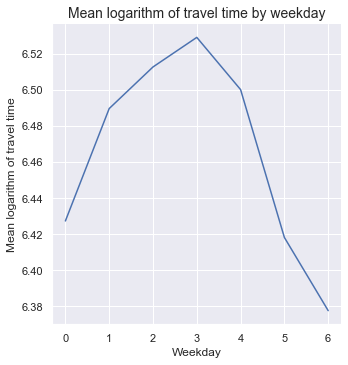

In [59]:
#your code for distribution of average trip duration by the number of day in a week is here:
tmp_data = train_data.groupby('day_of_week').log_trip_duration.mean()\
.reset_index().rename({
    'day_of_week': 'Weekday',
    'log_trip_duration': 'Mean logarithm of travel time'},
    axis=1
)

sns.relplot(data=tmp_data,
            x='Weekday',
            y='Mean logarithm of travel time',
            kind='line')
_ = plt.title('Mean logarithm of travel time by weekday', dict(size=14))
#end of your code

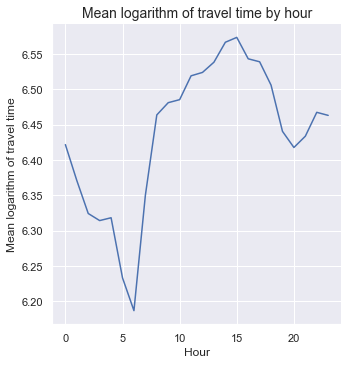

In [60]:
#your code for distribution of average trip duration by the hour of day is here:
tmp_data = train_data.groupby('hour').log_trip_duration.mean()\
.reset_index().rename({
    'hour': 'Hour',
    'log_trip_duration': 'Mean logarithm of travel time'},
    axis=1
)

sns.relplot(data=tmp_data,
            x='Hour',
            y='Mean logarithm of travel time',
            kind='line')
_ = plt.title('Mean logarithm of travel time by hour', dict(size=14))
#end of your code

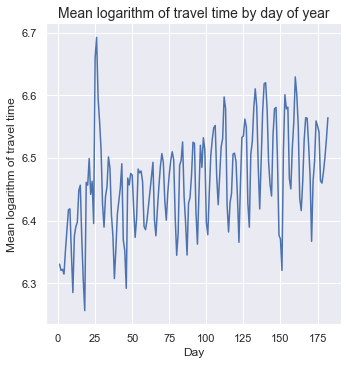

In [61]:
#your code for distribution of average trip duration by the number of day in the year is here:
tmp_data = train_data.groupby('day_of_year').log_trip_duration.mean()\
.reset_index().rename({
    'day_of_year': 'Day',
    'log_trip_duration': 'Mean logarithm of travel time'},
    axis=1
)

sns.relplot(data=tmp_data,
            x='Day',
            y='Mean logarithm of travel time',
            kind='line')
_ = plt.title('Mean logarithm of travel time by day of year', dict(size=14))
#end of your code

**Question**: Are the graphs of the target depending on the day of the week and on the hour of the day similar to those for the number of trips? Why? What happens to the average target in those two anomalous periods that we saw above? Why is this happening? Do you see any trend in the plot of `log_trip_duration` versus day of the year?

**Answer**: The more trips, the greater the mean value. The average target for abnormal periods is softened because of the logarithmic scale's ability to normalize a series of numbers. 

In general, the log_trip_duration vs. day of the year graph shows an upward trend.

So, we have already created a number of features.

**Question**: Which of the features should be considered as categorical, and which - as numerical? Why?

**Answer**: Numerical designations that denote a category of an object, such as an id or a color number, must be correlated to the categorical values. All other values, which can be up to infinity, such as price or waiting time, must be correlated to the number values.

In [62]:
train.head(1)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,log_trip_duration,day_of_year,hour,day_of_week,month,is_anomaly_jan,is_anomaly_may
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.96463,40.765602,N,6.122493,74,17,0,3,0,0


**Task 5**. Train `Ridge` regression with default parameters by encoding all categorical features with `OneHotEncoder`. Scale numerical features with `StandardScaler`. Use only the features that we have identified in this part of the task.

In [63]:
def make_pipeline(categorical, numeric, model):
    
    numeric_transformer = Pipeline(steps=[
          ('scaler', StandardScaler())
    ])
#your code for categorical transformer is here:  
    categorical_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical)
    ])
#end of ypur code
    preprocessor = ColumnTransformer(
       transformers=[
        ('numeric', numeric_transformer, numeric),
        ('categorical', categorical_transformer, categorical),
    ])
    
    pipeline = Pipeline(steps = [
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    return pipeline

def fit_pipeline(pipeline, train_data, test_data):    
#your code to is here:   
    pipeline.fit(train, train['log_trip_duration'])
#end of your code

    print('Train RMSE is {}'.format(RMSE(train_data[target], pipeline.predict(train_data.drop(target, axis=1)))))
    print('Test RMSE is {}'.format(RMSE(test_data[target], pipeline.predict(test_data.drop(target, axis=1)))))

In [65]:
#your list of categorical features is here:
categorical_columns = ['vendor_id','store_and_fwd_flag','day_of_year','hour','day_of_week','month','is_anomaly_jan','is_anomaly_may']
#your list of numerical features is here:
numeric_columns = ['passenger_count','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']
#your code to create pipeline is| here:
pipeline = make_pipeline(categorical_columns, numeric_columns, Ridge() )
#end of ypur code
fit_pipeline(pipeline, *train_test_split(train, random_state=42, test_size=0.3))

Train RMSE is 0.7705221136071952
Test RMSE is 0.7702553424506899


**Task 6**. Try to use any other way of categorical features encoding and normalization for numerical features. Train `Ridge` and `Lasso` regression for various encoding options and evaluate the results. Which one turned out to be the best? Why did other options show worse quality?

In [71]:

categorical_columns = ['vendor_id','store_and_fwd_flag','hour','day_of_week','month','is_anomaly_jan','is_anomaly_may']
numeric_columns = ['passenger_count','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']

pipeline1 = make_pipeline(categorical_columns, numeric_columns, Ridge())
pipeline2 = make_pipeline(categorical_columns, numeric_columns, Lasso())
print('Ridge regression:')
fit_pipeline(pipeline1, *train_test_split(train, random_state=42, test_size=0.3))
print('\n Lasso regression:')
fit_pipeline(pipeline2, *train_test_split(train, random_state=42, test_size=0.3))    

#end of your code

#end of your code

Ridge regression:
Train RMSE is 0.7713749018830397
Test RMSE is 0.7711395180160499

 Lasso regression:
Train RMSE is 0.7960728777410551
Test RMSE is 0.7950269278059048


**Task 7**. Use information about start and end points of trip (with help of the function below (use small part of data) to create at least one new feature which will increase your quality. Study its correlation with the target, explain the results logically, test different encoding options and find your best quality.

In [72]:
!pip install folium

In [73]:
import folium

In [74]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [75]:
show_circles_on_map(train.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [76]:
show_circles_on_map(train.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

In [81]:
#your code is here
from math import sin, cos, sqrt, atan2, radians
def Distance(row):
    R = 6373.0  # approximate radius of earth in km
    pickup_lat = radians(row['pickup_latitude'])
    pickup_lon = radians(row['pickup_longitude'])
    dropoff_lat = radians(row['dropoff_latitude'])
    dropoff_lon = radians(row['dropoff_longitude'])
    
    d_lon = dropoff_lon - pickup_lon
    d_lat = dropoff_lat - pickup_lat
    
    a = sin(d_lat / 2)**2 + cos(pickup_lat) * cos(dropoff_lat) * sin(d_lon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    result = R * c
    
    return result

#end of your code

In [82]:
train['trip_distance'] = train.apply(lambda row: Distance(row), axis= 1)
train.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,log_trip_duration,day_of_year,hour,day_of_week,month,is_anomaly_jan,is_anomaly_may,trip_distance
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,6.122493,74,17,0,3,0,0,1.498991
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,6.498282,164,0,6,6,0,0,1.806074
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,7.661527,19,11,1,1,0,0,6.387103
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,6.063785,97,19,2,4,0,0,1.485965
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,6.077642,86,13,5,3,0,0,1.188962


In [83]:
# numeric/categorical 
# list.append(feature)
numeric_columns.append(['trip_distance'])

# train model

In [84]:
categorical_columns = ['vendor_id','store_and_fwd_flag','hour','day_of_week','month','is_anomaly_jan','is_anomaly_may']
numeric_columns = ['passenger_count','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','trip_distance']

pipeline1 = make_pipeline(categorical_columns, numeric_columns, Ridge())
pipeline2 = make_pipeline(categorical_columns, numeric_columns, Lasso())
print('Ridge regression:')
fit_pipeline(pipeline1, *train_test_split(train, random_state=42, test_size=0.3))
print('\n Lasso regression:')
fit_pipeline(pipeline2, *train_test_split(train, random_state=42, test_size=0.3))  

Ridge regression:
Train RMSE is 0.6376979769360269
Test RMSE is 0.624654002309657

 Lasso regression:
Train RMSE is 0.7960728777410551
Test RMSE is 0.7950269278059048
